In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from plotnine import *

pd.options.display.max_rows = 40
pd.options.display.max_columns = 999999

In [2]:
import os
os.chdir("..")

# UDFs

In [3]:
def plot_boxplot_by_target(df, num_var, target_var, outliers_to_remove=None):
    """Make a box plot split by target using ggplot grammar of graphics
    Args:
    df (data.frame): dataset
    num_var (string): name of numeric variable for density estimation
    cluster_var (string): name of variable with target
    Yields:
    plot: Density plot for distributions split by target
    Examples:
    >>> plot_boxplot_by_target(dataset, "age", "target")
    """
    df[target_var] = df[target_var].astype('object')
    
    if not(pd.isnull(outliers_to_remove)):
        if (type(outliers_to_remove) == float):
            quantiles = df[num_var].quantile([outliers_to_remove,
                                              1 - outliers_to_remove])
            df = df.loc[((df[num_var] > quantiles.iloc[0])
                        & (df[num_var] < quantiles.iloc[1])), :]
    try:
        g = (ggplot(df)
             + geom_boxplot(aes(x=target_var, y=num_var, fill=target_var))
             + ggtitle(num_var)
             + theme_light()
             + scale_fill_brewer(type="qual", palette="Dark2"))
        return print(g)
    except Exception:
        pass
    
def plot_share_of_categorical_vars_by_target(df, var, target_var):
    """Make a column plot colored by clusters using ggplot grammar of graphics
    to present share of given binery/categorical var split by target
    Args:
    df (data.frame): dataset
    var (string): name of variable for x axis
    cluster_var (string): name of variable with target
    Yields:
    plot: Column plot with share of each category in given categroical variable 
    split by target
    Examples:
    >>> plot_share_of_categorical_vars_by_target(dataset, "flag_own_car",
                                               "target")
    """
    df = df.loc[:, [var, target_var]]
    df = df.groupby([var, target_var]).value_counts()
    df = df.reset_index().rename(columns={0: 'n'})
    df['n_cluster'] = df.groupby([target_var]).n.transform('sum')
    df['share'] = round(100 * df['n'] / df['n_cluster'], 1)

    df[target_var] = df[target_var].astype('object')
    df[var] = df[var].astype('object')
    
    g = (ggplot(df)
         + geom_col(aes(x=var, y="share", fill=target_var))
         + facet_wrap('~' + target_var)
         + theme_light()
         + theme(legend_position="top")
         + theme(axis_text_x=element_text(rotation=90, hjust=1))
         + scale_fill_brewer(type="qual", palette="Dark2"))
    print(g)

# Data load

In [4]:
df_merged = pd.read_pickle('data/processed/df_application_record_classified_raw.pickle')

# Feature engineerging

In [5]:
df_merged.occupation_type = df_merged.occupation_type.fillna("Unknown")
df_merged['amt_income_per_person'] = df_merged['amt_income_total'] / df_merged['cnt_fam_members']
df_merged['age'] = -1 * df_merged['days_birth'] / 365
df_merged['job_tenure'] = -1 * df_merged['days_employed'] / 365
df_merged['job_tenure'] = np.where(df_merged["days_employed"] > 0, -1, df_merged['job_tenure'])
df_merged['flag_employed'] = np.where(df_merged["days_employed"] > 0, 0, 1)
df_merged['code_gender'] = np.where(df_merged['code_gender'] == 'M', 1, 0)
df_merged['flag_own_car'] = np.where(df_merged['flag_own_car'] =='Y', 1, 0)
df_merged['flag_own_realty'] = np.where(df_merged['flag_own_realty'] =='Y', 1, 0)
df_merged['single_adult'] = np.where(
    (df_merged['name_family_status'] =='Married') | (df_merged['name_family_status'] == 'Civil marriage'), 0, 1)
df_merged['target'] = np.where((df_merged['customer_status'] =='bad customer') | (df_merged['customer_status'] =='moderate customer'), 1, 0)
df_merged = df_merged.astype({'flag_own_car': int, 
                                'flag_own_realty': int, 
                                'cnt_children': int,
                                'cnt_fam_members': int})

In [6]:
df_merged.target.value_counts().to_frame('count').join(
    df_merged.target.value_counts(normalize = True).to_frame('share'))

count     share
0  19687  0.984547
1    309  0.015453

In [7]:
# check - there should be no people with flag_work_phone = 1 and flag_employed = 0
df_merged.groupby(['flag_work_phone', 'flag_employed'])['flag_employed'].count().unstack()

flag_employed         0        1
flag_work_phone                 
0                3240.0  12172.0
1                   NaN   4584.0

In [8]:
df_merged.groupby(['name_family_status', 'single_adult'])['single_adult'].count().unstack()

single_adult                0       1
name_family_status                   
Civil marriage         1526.0     NaN
Married               14016.0     NaN
Separated                 NaN  1181.0
Single / not married      NaN  2517.0
Widow                     NaN   756.0

In [9]:
# check age and tenure distribution

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 35'. Pick better value with 'binwidth'.


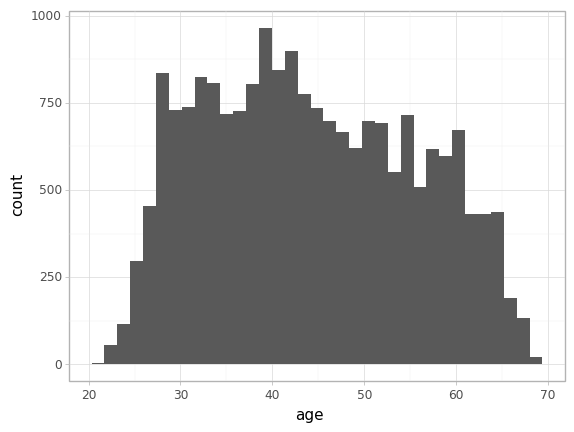

<ggplot: (126900540642)>

In [10]:
(ggplot(df_merged)
 + geom_histogram(aes(x = 'age'))
 + theme_light()
 + xlab('age'))

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 78'. Pick better value with 'binwidth'.


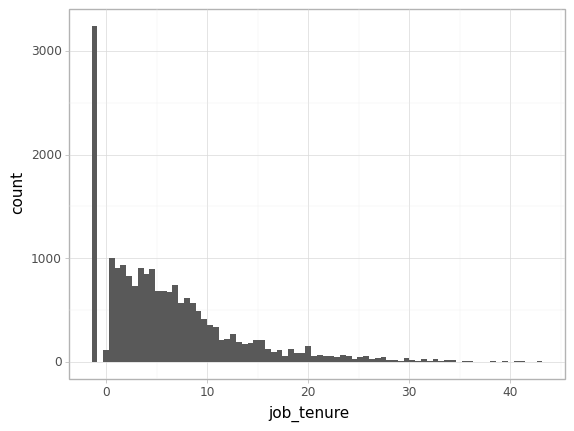

<ggplot: (126902201073)>

In [11]:
(ggplot(df_merged)
 + geom_histogram(aes(x = 'job_tenure'))
 + theme_light()
 + xlab('job_tenure'))

In [12]:
df_merged = df_merged.drop(['flag_mobil', 'flag_work_phone', 'flag_phone', 
                              'flag_email', 'days_birth', 'days_employed',
                              'name_family_status', 'customer_status'], axis = 1)
df_merged

code_gender  flag_own_car  flag_own_realty  cnt_children  \
id                                                                  
5008804            1             1                1             0   
5008805            1             1                1             0   
5008806            1             1                1             0   
5008810            0             0                1             0   
5008811            0             0                1             0   
...              ...           ...              ...           ...   
5149729            1             1                1             0   
5149775            0             1                1             0   
5149834            0             0                1             0   
5149838            0             0                1             0   
5150337            1             0                1             0   

         amt_income_total      name_income_type  \
id                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008810          270000.0  Commercial associate   
5008811          270000.0  Commercial associate   
...                   ...                   ...   
5149729           90000.0               Working   
5149775          130500.0               Working   
5149834          157500.0  Commercial associate   
5149838          157500.0             Pensioner   
5150337          112500.0               Working   

                   name_education_type  name_housing_type occupation_type  \
id                                                                          
5008804               Higher education   Rented apartment         Unknown   
5008805               Higher education   Rented apartment         Unknown   
5008806  Secondary / secondary special  House / apartment  Security staff   
5008810  Secondary / secondary special  House / apartment     Sales staff   
5008811  Secondary / secondary special  House / apartment     Sales staff   
...                                ...                ...             ...   
5149729  Secondary / secondary special  House / apartment         Unknown   
5149775  Secondary / secondary special  House / apartment        Laborers   
5149834               Higher education  House / apartment  Medicine staff   
5149838               Higher education  House / apartment  Medicine staff   
5150337  Secondary / secondary special   Rented apartment        Laborers   

         cnt_fam_members  amt_income_per_person        age  job_tenure  \
id                                                                       
5008804                2               213750.0  32.890411   12.443836   
5008805                2               213750.0  32.890411   12.443836   
5008806                2                56250.0  58.832877    3.106849   
5008810                1               270000.0  52.356164    8.358904   
5008811                1               270000.0  52.356164    8.358904   
...                  ...                    ...        ...         ...   
5149729                2                45000.0  52.331507    4.715068   
5149775                2                65250.0  44.210959   25.728767   
5149834                2                78750.0  33.936986    3.630137   
5149838                2                78750.0  33.936986    3.630137   
5150337                1               112500.0  25.172603    3.268493   

         flag_employed  single_adult  target  
id                                            
5008804              1             0       0  
5008805              1             0       0  
5008806              1             0       0  
5008810              1             1       0  
5008811              1             1       0  
...                ...           ...     ...  
5149729              1             0       0  
5149775              1             0       0  
5149834     

In [13]:
df_merged.to_pickle('data/processed/df_application_record_classified_post_feature_eng.pickle')

# Relationship analysis

In [14]:
from scipy.stats import chi2_contingency, pointbiserialr
alpha = 0.05

## Relationship between categorical variables

In [15]:
cat_vars = ['code_gender', 'flag_own_car', 'flag_own_realty', 
            'name_income_type', 'name_education_type',
            'name_housing_type', 'occupation_type',
            'flag_employed','single_adult']

for var in cat_vars:
    print(var)
    tb = pd.crosstab(index = df_merged['target'].astype('object'),
                     columns = df_merged[var].astype('object'))

    _, p_value, _, _ = chi2_contingency(tb)

    if p_value <= alpha:
        print('Dependent (reject H0). p value equals ' + str(round(p_value, 4)))
    else:
        print('Independent (H0 holds true). p value equals ' + str(round(p_value, 4)))

code_gender
Dependent (reject H0). p value equals 0.0019
flag_own_car
Independent (H0 holds true). p value equals 0.9479
flag_own_realty
Independent (H0 holds true). p value equals 0.4166
name_income_type
Dependent (reject H0). p value equals 0.0304
name_education_type
Dependent (reject H0). p value equals 0.0006
name_housing_type
Independent (H0 holds true). p value equals 0.1033
occupation_type
Independent (H0 holds true). p value equals 0.1178
flag_employed
Independent (H0 holds true). p value equals 0.6895
single_adult
Dependent (reject H0). p value equals 0.0308


### Plots

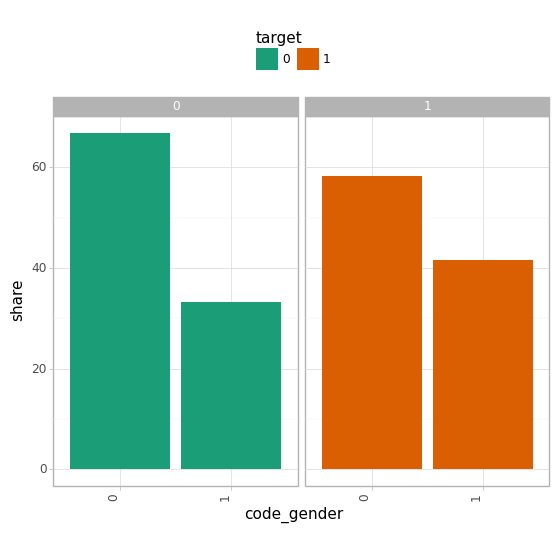

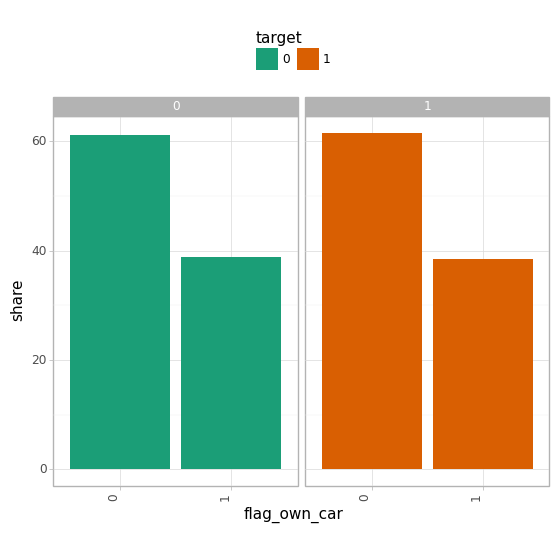

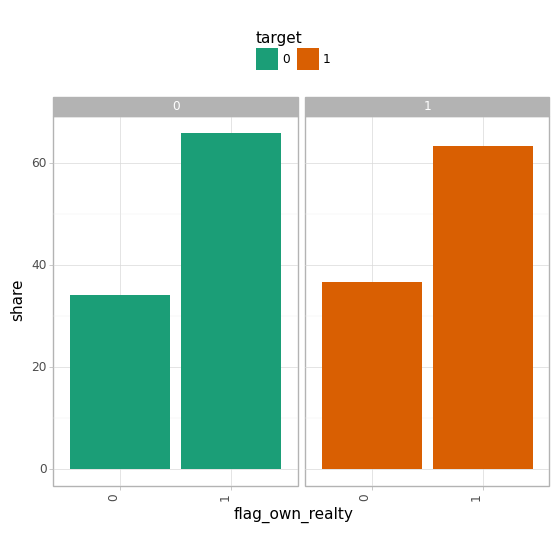

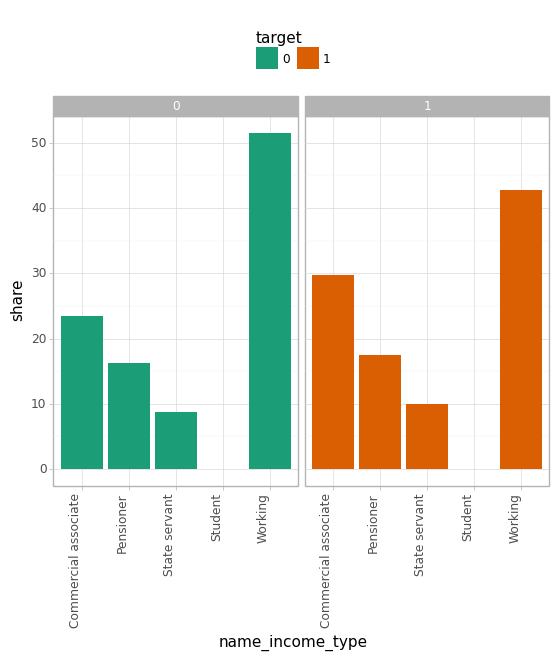

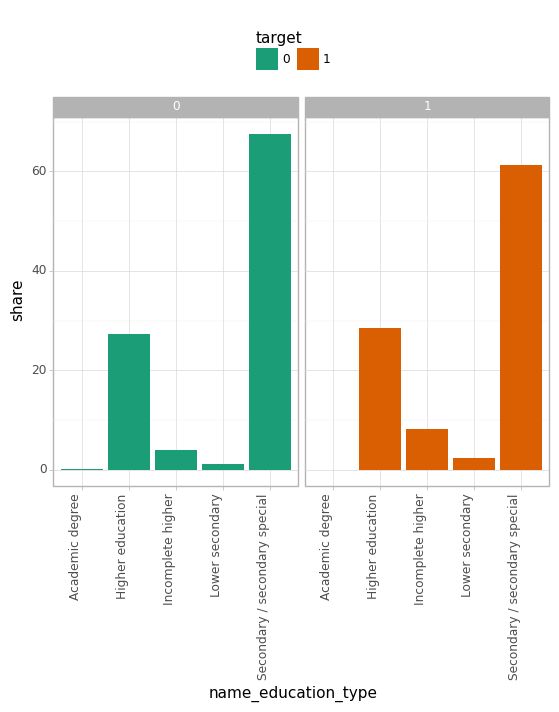

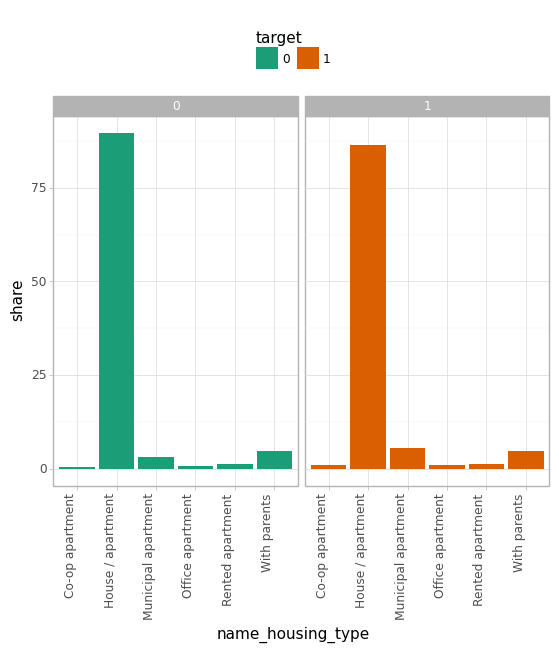

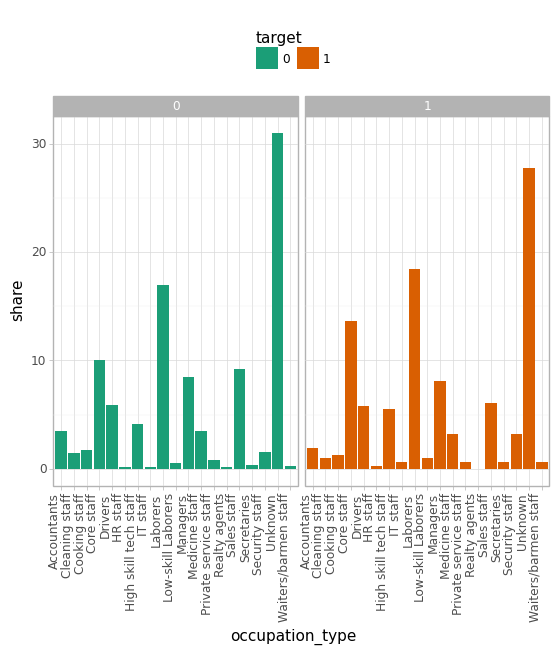

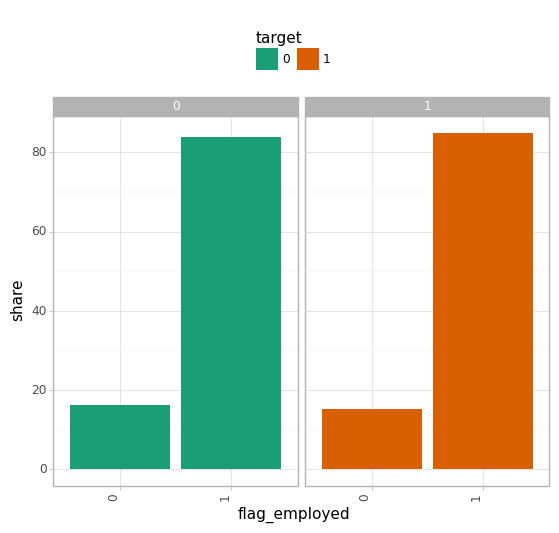

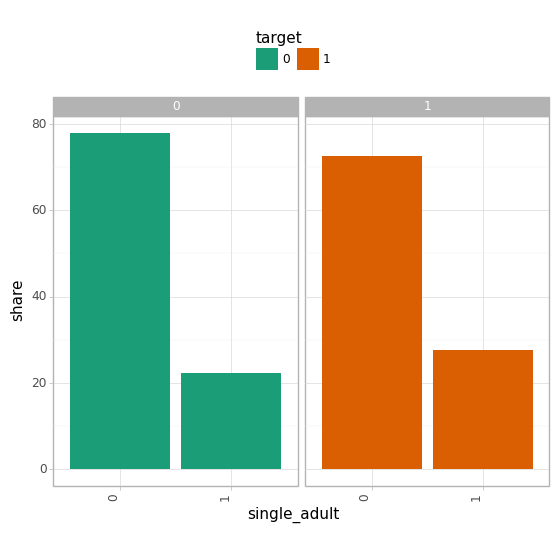

In [16]:
for var in cat_vars:
    plot_share_of_categorical_vars_by_target(df_merged, var, "target")

## Relationship between a binary and a continuous variable

### Point biserial correlation

In [18]:
num_vars = ['amt_income_total', 'amt_income_per_person', 'age',
            'job_tenure', 'cnt_fam_members', 'cnt_children']

for var in num_vars:
    print(var)
    cor_pbs, p_value = pointbiserialr(df_merged['target'], df_merged[var])
    if p_value <= alpha:
        print('Correlation is signifincat (p-value: ' + str(round(p_value, 4)) + ').')
        print('Point biserial correlation equals ' + str(round(cor_pbs, 4)))
    else:
        print('Correlation is NOT signifincat (p-value: ' + str(round(p_value, 4)) + ').')
        print('Point biserial correlation equals ' + str(round(cor_pbs, 4)))

amt_income_total
Correlation is NOT signifincat (p-value: 0.1927).
Point biserial correlation equals 0.0092
amt_income_per_person
Correlation is signifincat (p-value: 0.0461).
Point biserial correlation equals 0.0141
age
Correlation is NOT signifincat (p-value: 0.1818).
Point biserial correlation equals -0.0094
job_tenure
Correlation is signifincat (p-value: 0.0328).
Point biserial correlation equals -0.0151
cnt_fam_members
Correlation is NOT signifincat (p-value: 0.7257).
Point biserial correlation equals -0.0025
cnt_children
Correlation is NOT signifincat (p-value: 0.7131).
Point biserial correlation equals 0.0026


### Plots

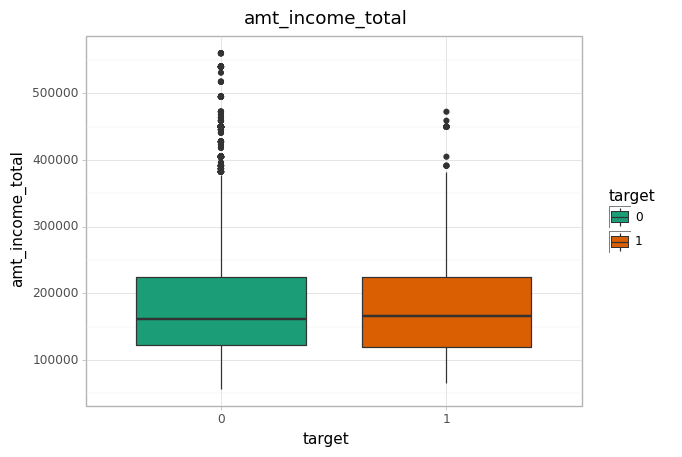

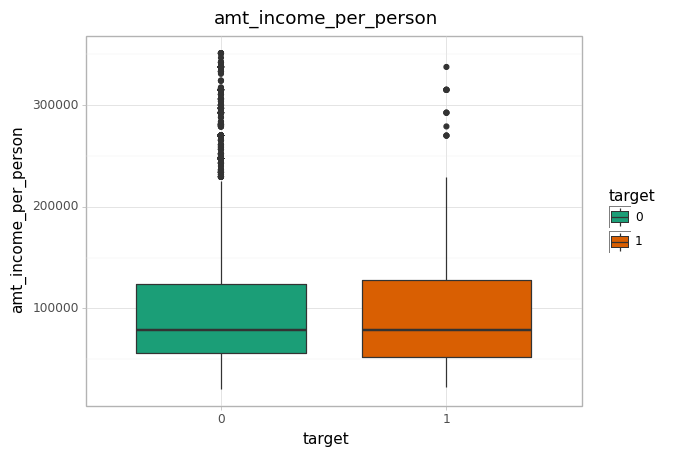

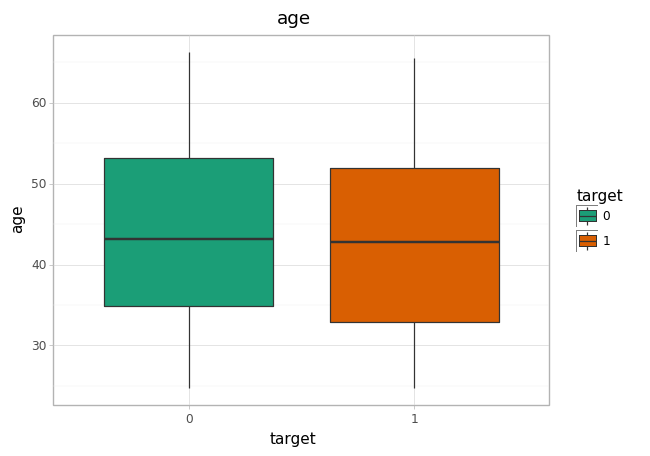

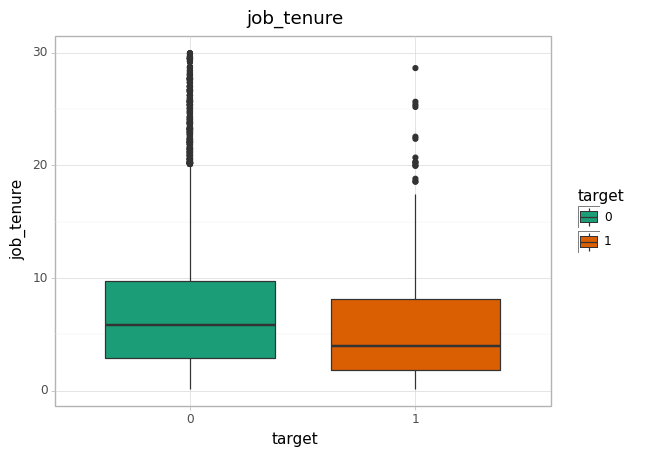

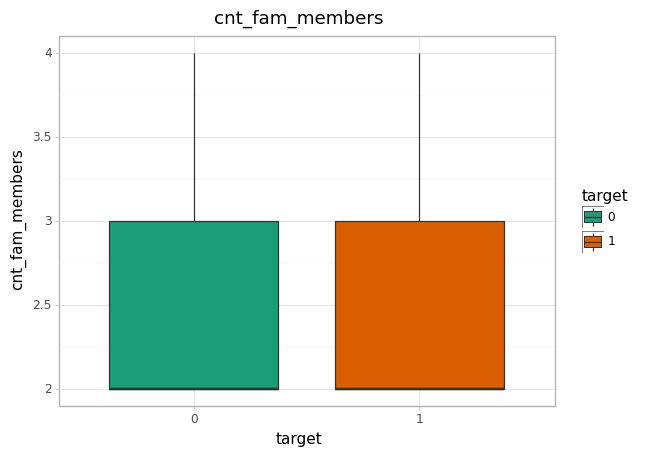

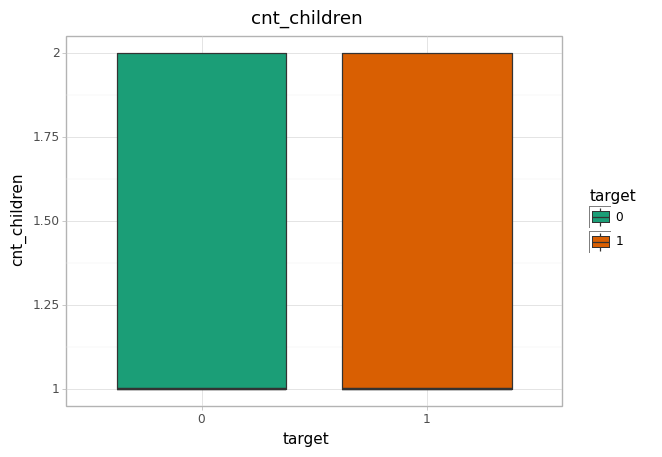

In [19]:
for var in num_vars:
    plot_boxplot_by_target(df_merged, var, "target", 0.01)

# Profiling report

In [20]:
pandas_profiling_post_feat_eng = ProfileReport(df_merged, title = "Report - pandas_profiling - post feature engineering")
pandas_profiling_post_feat_eng.to_file("reports/Report pandas-profiler - post feature engineering.html")
pandas_profiling_post_feat_eng.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]